## Neural network playing ground (Small Methods Imgs)
### Nov 2023 - Code by Mauricio Cano Galván

Library Import

In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy


from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import colormaps
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from scipy.stats import norm
import seaborn as sns
import math
from tqdm import tqdm

from nn_backend.import_xyz_img import import_xyz_img
from nn_backend.conv_imgs import conv_imgs
from nn_backend.data_import import import_curves_from_folder, curve_calibration, matrix_cut, data_augment, mask_from_topo
from nn_backend.nn_for_ep import nn_for_ep
from nn_backend.post_process import img_export, histogram_export
from nn_backend.extras import simulation_table_import


viridis = colormaps['viridis']
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0, 0, 0, 1])
newcolors[0:13, :] = black
newcmp = ListedColormap(newcolors)
del black, newcolors, viridis

In [283]:
#Program configuration

#Data import
name='efm9' #Filename with which to save exports
topography_file=rf'c:\Users\mcano\Code\rawdata\img_data\EFM7\EFM7 Topography Flattened_Mirror.txt'
ref_file=rf"c:\Users\mcano\Code\rawdata\img_data\EFM7\ep_TopoRecostruction.txt"
sim_tables_folder=rf'C:\Users\mcano\Code\rawdata\img_data\Bacterias_Ruben\Out_Get_10_EpOnpx_2024-5-16-12-17\tablas'
lift_imgs_folder=rf'c:\Users\mcano\Code\rawdata\preprocessed curves\efm7_curves_calibrated.npy'
raw_curves_folder=0
calibrate_curves=1
ref_flip=1
topo_flip=1


#Curve pre-processing
curves_max_limit=1000 #Maximum height [nm] to which the approximation curves will be projected
curve_nsamples=12 #Number of samples to take from approximation curves
curve_height_setpoint=20 #First curve height [nm] to take in consideration for sampling


#Optional graphics to show in notebook (1 to show images, 0 to hide)
input_imgs_view=1


#Neural Network Setup
pctg=90 #Percentage of train data
cutout_size=9 #Size of the topography cutouts for the convolution operation
kernel_dim=3 #Kernel dimension for the convolution operation
iterations=300
batch_sz=200 #Batch size for training

#Mask configuration. The following images should be processed using the values established.

    #EFM9: binary_threshold=0.04, object_size=3, hole_size=30, m_thresh=0.30
    #EFM8: binary_threshold=0.41, object_size=3, hole_size=30, m_thresh=0.77
    #EFM7: binary_threshold=0.095, object_size=4, hole_size=15, m_thresh=0.44
    #EFVM: binary_threshold=0.05, object_size=2, hole_size=2, m_thresh=0.785
    #newbact: binary_threshold=0.067, object_size=3, hole_size=30, m_thresh=0.30
binary_threshold=0.095
object_size=4
hole_size=15
m_ep_thresh=0.44


index_select=150

Data Import

In [ ]:
class input_for_nn:
    def __init__(self) -> None:
        pass
    def preproc(self):
        dimtest, x, y2 = import_xyz_img(topography_file)
        og_dim=len(dimtest)
        pix_len=np.max(x)/len(x)


        use_lift_files=0
        if use_lift_files:
            lifts=[20,30,40,80,150]
            samples=lifts
            lift_samples=np.zeros((og_dim,og_dim,1))
            for l in lifts:
                file, ax_ep, ay_ep= import_xyz_img(rf'{lift_imgs_folder}\LiftPower_{l}_.txt')
                file=np.expand_dims(file,axis=-1)
                lift_samples=np.concatenate((lift_samples,file), axis=-1)
                
            lift_samples=lift_samples[:,:,1:]

            
        #------Import the label data (εp map), as a matrix first and then transformed into a DataFrame.------#
        #----------The data is then cleaned to remove outliers


        y_mat, ax_ep, ay_ep= import_xyz_img(ref_file)
        nu_dim=np.min([og_dim-cutout_size+1,len(y_mat)])

        if ref_flip:
            y_mat=np.flipud(y_mat)
        y_mat=matrix_cut(y_mat,nu_dim)
        y=pd.DataFrame(np.reshape(y_mat,nu_dim**2))


        #Logarithmic sampling
        zetas=np.arange(curves_max_limit)
        maxlen=1713


        zs=np.round((np.logspace(start=0,stop=math.log10(maxlen),num=curve_nsamples,endpoint=False)+curve_height_setpoint)).astype(int)
        samples = []
        [samples.append(x) for x in zs if x not in samples]


        if use_lift_files:
            curves_sampled=matrix_cut(lift_samples, nu_dim)
            curves_sampled=curves_sampled.reshape(nu_dim*nu_dim,len(lifts))
            #curves_sampled=curves_sampled[:3]
            b=np.zeros((curves_max_limit,1))

            zzz=np.array(lifts)
            projection = np.full((len(curves_sampled),len(zetas)), np.nan)
            for h in tqdm(np.arange(len(curves_sampled))):
                ccc=curves_sampled[h,:]
                indices = np.where(np.isin(zetas, zzz.astype(int)))[0]
                projection[h, indices] = ccc[np.isin(np.round(zzz), zetas)]
            projection=pd.DataFrame(projection)
            projection=projection.interpolate(axis=1)
            projection=projection.bfill(axis=1)
            curves_sampled=np.array(projection).reshape(nu_dim,nu_dim,curves_max_limit)
            curves_sampled=curves_sampled[:,:,samples]
            
        else:
            # if not raw_curves_folder:
            curves_projected=pd.DataFrame(np.load(rf'{lift_imgs_folder}'))
            curves_projected=curves_projected.interpolate(axis=1)
            curves_projected=curves_projected.bfill(axis=1)

            #New curves
            curves=(np.array(curves_projected)).reshape(og_dim,og_dim,len(curves_projected.iloc[0,:]))
            curves=matrix_cut(curves, nu_dim)
            curves_sampled=curves[:,:,samples]


        #Topography import
        T_mat, x, y2 = import_xyz_img(topography_file)
        if topo_flip:
            T_mat=np.flipud(T_mat)
        T_mat=matrix_cut(T_mat, nu_dim)
        T_mat=np.expand_dims(T_mat, axis=2)
        T=T_mat.reshape(nu_dim**2)
        #Put together training dataset
        pixlen_mat=np.zeros_like(T_mat)+pix_len
        # X_mat=np.concatenate((T_mat, curves_sampled), axis=2)
        X_mat=np.concatenate((T_mat, pixlen_mat, curves_sampled), axis=2)

        aa=["Z = "+str(x)+" nm" for x in samples]
        inputs=["Topography", "Pixel Width"]
        inputs=np.append(inputs, aa)

        X=np.reshape(X_mat,(nu_dim**2,len(X_mat[0,0,:])))
        X=pd.DataFrame(X, columns=inputs)


        plt.subplot(1,2,1)
        plt.imshow(T_mat, cmap='hot')
        plt.title('Topography')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(y_mat, cmap=newcmp, vmin=-1, vmax=8)
        plt.title('$ε_p$ map')
        plt.axis('off')


        if input_imgs_view:
            fig=plt.figure(figsize=(12,10))
            ax=fig.add_subplot(5,3,1)
            pcm=ax.imshow(X_mat[:,:,0], cmap='hot')
            ax.set_title("Topography")
            plt.colorbar(pcm, label="nm")
            ax.axis('off')

            ax=fig.add_subplot(5,3,2)
            pcm=ax.imshow(X_mat[:,:,1], cmap='hot')
            ax.set_title("Pixel Width")
            plt.colorbar(pcm, label="nm")
            ax.axis('off')
            for i in range(3,len(X.iloc[0])+1):
                ax=fig.add_subplot(5,3,i)
                pcm=ax.imshow(X_mat[:,:,i-1], cmap='hot', vmin=0.0, vmax=0.9)
                h=samples[i-3]
                ax.set_title("Lift; Z = "+str(h)+" nm")
                plt.colorbar(pcm, label="$dC/dz$")
                ax.axis('off')
            

        # binary_threshold=0.9905
        # object_size=3
        # hole_size=30
        # m_ep_thresh=0.30

        # masker=abs(1-X.iloc[:,1])
        masker=T

        bin=mask_from_topo(masker,binary_threshold,object_size,hole_size)

        cell=bin.reshape(nu_dim**2,1)
        roi_index=pd.DataFrame(copy(cell))
        roi_index=roi_index.index[(roi_index[0])]


        mask_ep=pd.DataFrame(copy(y))
        th=float(mask_ep.quantile(m_ep_thresh))

        mask_ep[(mask_ep[0]<=th)]=0
        mask_ep[(mask_ep[0]!=0)]=1
        mask_ep=cell*mask_ep

        cell_index=mask_ep.index[mask_ep[0]>0].tolist()

        
        if index_select!='':
            select_index = np.random.choice(cell_index, size=index_select, replace=False)
            y_select=pd.DataFrame(y.iloc[select_index])
            X_select=pd.DataFrame(X.iloc[select_index])

        mask_ep_im=np.reshape(np.array(mask_ep), ((nu_dim),(nu_dim)))



        fig=plt.figure(figsize=(10,7))
        ax=fig.add_subplot(1,2,1)
        ax.imshow(bin, cmap='gray')
        ax.set_title('ROI mask')
        ax.axis('off')
        ax=fig.add_subplot(1,2,2)
        ax.imshow(mask_ep_im)
        ax.axis('off')
        ax.set_title('Final Train Mask')

        #------Cell separation------#
        y_cell=pd.DataFrame(y.iloc[cell_index])
        X_cell=pd.DataFrame(X.iloc[cell_index])
        y_roi=pd.DataFrame(y.iloc[roi_index])
        X_roi=pd.DataFrame(X.iloc[roi_index])



        #------Data Normalization------#
        curve_scale=StandardScaler()
        curve_scale.fit(X_cell)
        Xn_cell=pd.DataFrame(curve_scale.transform(X_cell), columns=inputs)
        Xn_roi=pd.DataFrame(curve_scale.transform(X_roi), columns=inputs)
        if index_select!='':
            Xn_select=pd.DataFrame(curve_scale.transform(X_select), columns=inputs)


        #------Data Normalization------#
        curve_scale=StandardScaler()
        curve_scale.fit(X_cell)
        Xn_cell=pd.DataFrame(curve_scale.transform(X_cell), columns=inputs)

        topo_mat, x, y2 = import_xyz_img(topography_file)
        topo=topo_mat.reshape(len(topo_mat)**2,1)

        topo_scale=StandardScaler()
        topo_scale.fit(topo)
        topo_n=topo_scale.transform(topo)
        topo_n_mat=topo_n.reshape(len(topo_mat),len(topo_mat),1)
        self.topo_n_mat=topo_n_mat
        self.nu_dim=nu_dim
        self.cell_index=cell_index
        self.roi_index=roi_index
        self.Xn_roi=Xn_roi
        self.y_mat=y_mat
        self.y=y
        self.y_cell=y_cell
        self.T_mat=T_mat
        self.Xn_cell=Xn_cell
        self.X_mat=X_mat
        self.Xn_train_input=Xn_cell
        self.y_train_input=y_cell
        self.pixel_width=pix_len
        if index_select!='':
            self.select_index=select_index
            self.y_select=y_select
            self.Xn_select=Xn_select
    def convolution(self):

        topo_n_mat=self.topo_n_mat
        nu_dim=self.nu_dim
        cell_index=self.cell_index
        roi_index=self.roi_index
        if index_select!='':
            select_index=self.select_index

    
        full_cutouts=0
  
        if full_cutouts:
            Cv_mat=conv_imgs(topo_n_mat[:,:,0], cutout_size)
            Cv_mat=Cv_mat.reshape(int(math.sqrt(len(Cv_mat))),int(math.sqrt(len(Cv_mat))),cutout_size,cutout_size)
            Cv_mat=matrix_cut(Cv_mat, nu_dim)

            Cv_mat=Cv_mat.reshape(nu_dim*nu_dim,cutout_size,cutout_size)
            Cv_mat=np.expand_dims(Cv_mat, axis=-1)

            Cv_mat=Cv_mat.reshape(nu_dim*nu_dim,cutout_size,cutout_size)
            Cv_mat=np.expand_dims(Cv_mat, axis=-1)
            Cv_cell_mat=Cv_mat[cell_index,:,:,:]
            Cv_roi_mat=Cv_mat[roi_index,:,:,:]
            if index_select!='':
                Cv_sel_mat=Cv_mat[select_index,:,:,:]
        else:
            y_coord, x_coord= np.unravel_index(cell_index, (nu_dim, nu_dim))
            cell_index_2=np.transpose(np.column_stack((y_coord, x_coord)))
            cell_index_2[0]=cell_index_2[0]+int((cutout_size-1)/2)
            cell_index_2[1]=cell_index_2[1]+int((cutout_size-1)/2)

            y_coord, x_coord= np.unravel_index(roi_index, (nu_dim, nu_dim))
            roi_index_2=np.transpose(np.column_stack((y_coord, x_coord)))
            roi_index_2[0]=roi_index_2[0]+int((cutout_size-1)/2)
            roi_index_2[1]=roi_index_2[1]+int((cutout_size-1)/2)
            if index_select!='':
                y_coord, x_coord= np.unravel_index(select_index, (nu_dim, nu_dim))
                select_index_2=np.transpose(np.column_stack((y_coord, x_coord)))
                select_index_2[0]=select_index_2[0]+int((cutout_size-1)/2)
                select_index_2[1]=select_index_2[1]+int((cutout_size-1)/2)

            Cv_cell_mat=conv_imgs(topo_n_mat[:,:,0], cutout_size, cell_index_2)
            Cv_roi_mat=conv_imgs(topo_n_mat[:,:,0], cutout_size, roi_index_2)
            Cv_cell_mat=np.expand_dims(Cv_cell_mat, axis=-1)
            Cv_roi_mat=np.expand_dims(Cv_roi_mat, axis=-1)
            if index_select!='':
                Cv_sel_mat=conv_imgs(topo_n_mat[:,:,0], cutout_size, select_index_2)
                Cv_sel_mat=np.expand_dims(Cv_sel_mat, axis=-1)


            
        self.Cv_roi_mat=Cv_roi_mat
        self.Cv_cell_mat=Cv_cell_mat
        self.Cv_sel_mat=Cv_sel_mat




C:\Users\mcano\AppData\Local\Temp\ipykernel_11952\1678963945.py:144: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  th=float(mask_ep.quantile(m_ep_thresh))
100%|██████████| 150/150 [00:00<00:00, 30009.33it/s]


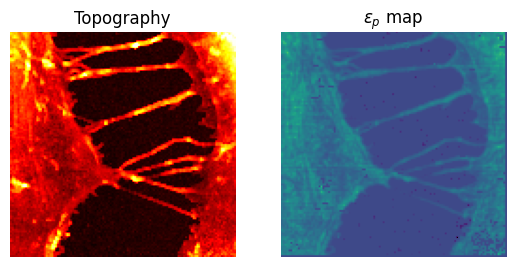

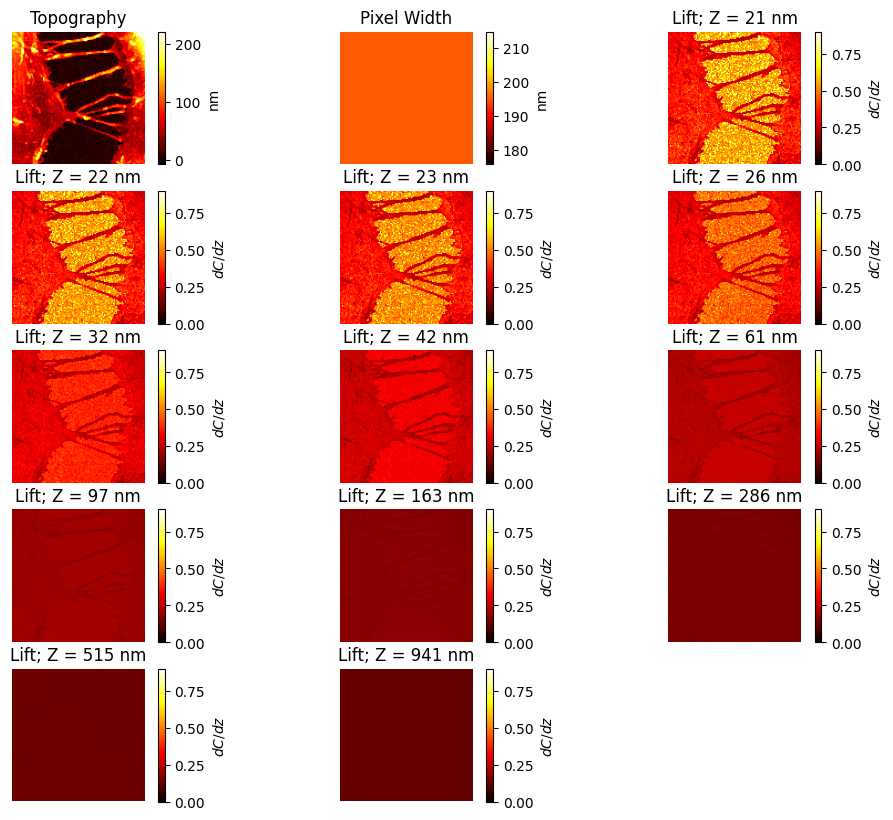

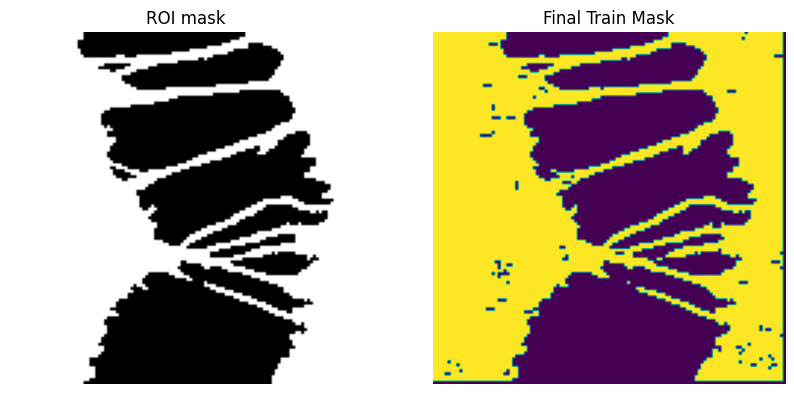

In [287]:
a=input_for_nn()
a.preproc()
a.convolution()

C:\Users\mcano\AppData\Local\Temp\ipykernel_11952\1678963945.py:144: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  th=float(mask_ep.quantile(m_ep_thresh))
100%|██████████| 150/150 [00:00<00:00, 37525.09it/s]


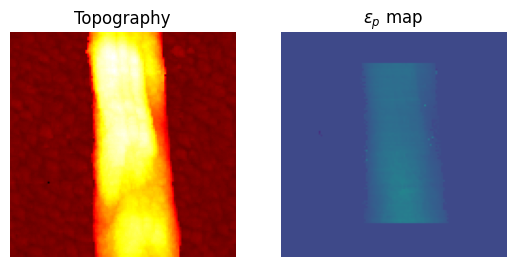

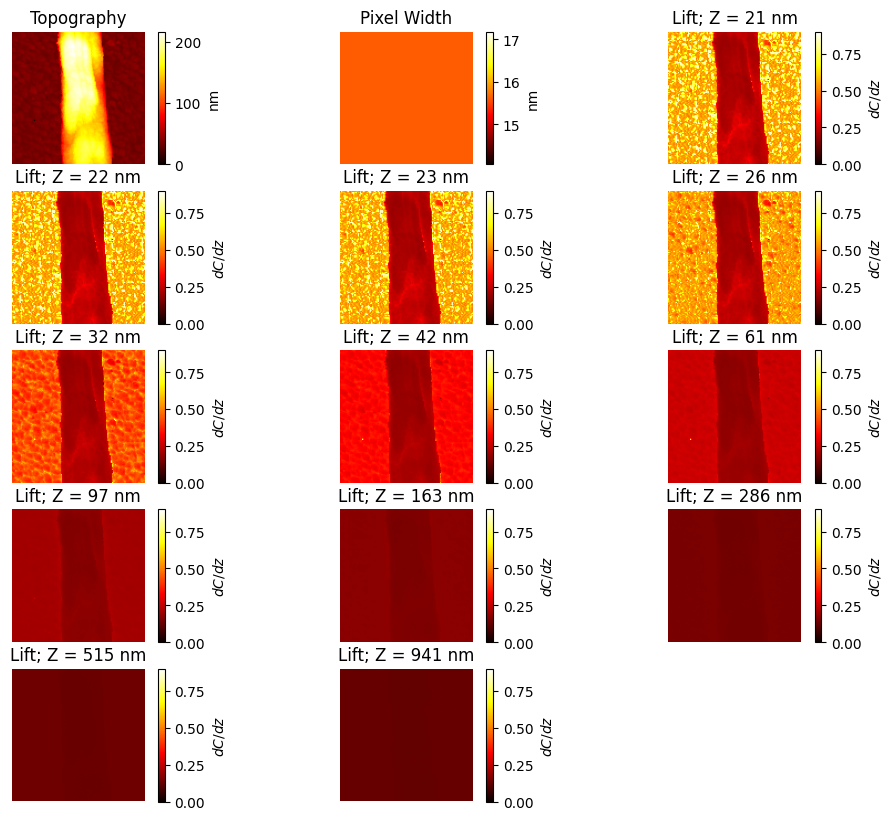

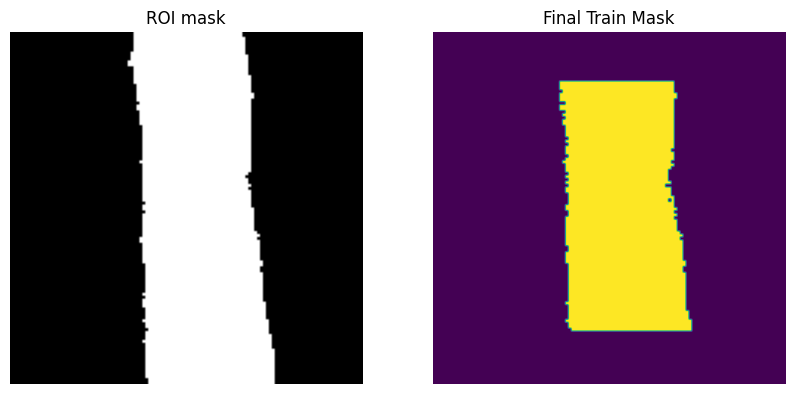

In [288]:
name='efm9' #Filename with which to save exports
topography_file=rf'c:\Users\mcano\Code\rawdata\img_data\EFM8\Topography Flattened EFM8.txt'
ref_file=rf"c:\Users\mcano\Code\rawdata\img_data\EFM8\Map_Nanofilament.txt"
sim_tables_folder=rf'C:\Users\mcano\Code\rawdata\img_data\Bacterias_Ruben\Out_Get_10_EpOnpx_2024-5-16-12-17\tablas'
lift_imgs_folder=rf'c:\Users\mcano\Code\rawdata\preprocessed curves\efm8_curves_calibrated.npy'
raw_curves_folder=0
calibrate_curves=1
ref_flip=1
topo_flip=0

#Curve pre-processing
curves_max_limit=1000 #Maximum height [nm] to which the approximation curves will be projected
curve_nsamples=12 #Number of samples to take from approximation curves
curve_height_setpoint=20 #First curve height [nm] to take in consideration for sampling


#Optional graphics to show in notebook (1 to show images, 0 to hide)
input_imgs_view=1


#Neural Network Setup
pctg=90 #Percentage of train data
cutout_size=9 #Size of the topography cutouts for the convolution operation
kernel_dim=3 #Kernel dimension for the convolution operation
iterations=300
batch_sz=200 #Batch size for training

#Mask configuration. The following images should be processed using the values established.

    #EFM9: binary_threshold=0.04, object_size=3, hole_size=30, m_thresh=0.30
    #EFM8: binary_threshold=0.41, object_size=3, hole_size=30, m_thresh=0.77
    #EFM7: binary_threshold=0.095, object_size=4, hole_size=15, m_thresh=0.44
    #EFVM: binary_threshold=0.05, object_size=2, hole_size=2, m_thresh=0.785
    #newbact: binary_threshold=0.067, object_size=3, hole_size=30, m_thresh=0.30
binary_threshold=0.41
object_size=3
hole_size=30
m_ep_thresh=0.77

b=input_for_nn()
b.preproc()
b.convolution()

index_select=''

C:\Users\mcano\AppData\Local\Temp\ipykernel_11952\1678963945.py:144: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  th=float(mask_ep.quantile(m_ep_thresh))


AttributeError: 'input_for_nn' object has no attribute 'select_index'

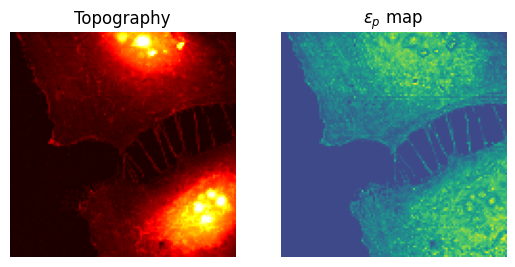

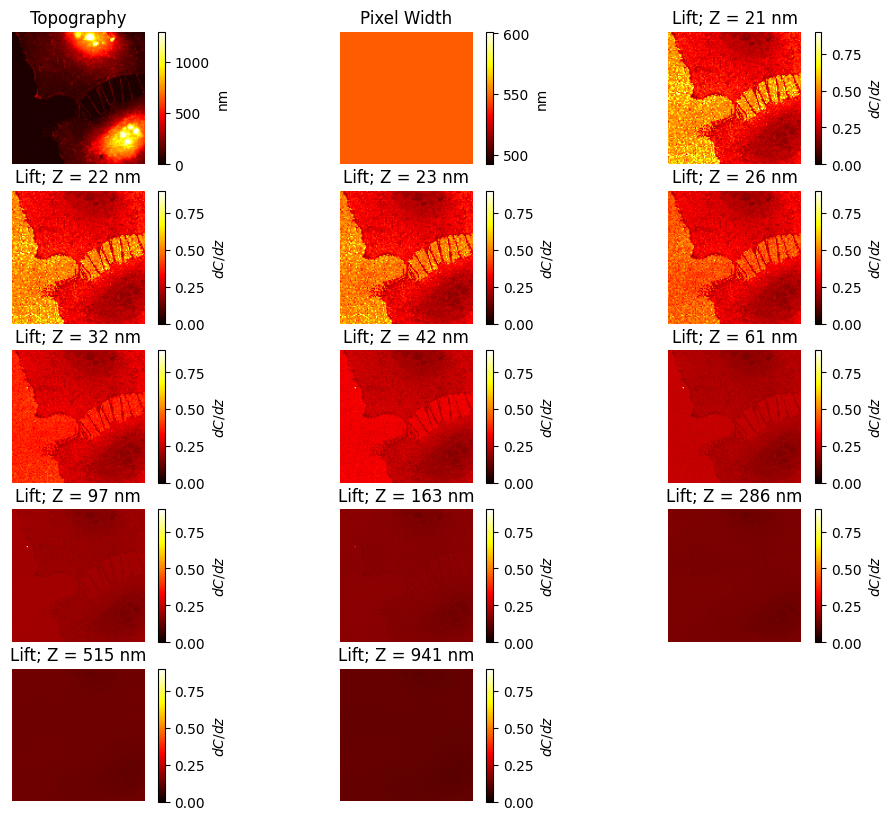

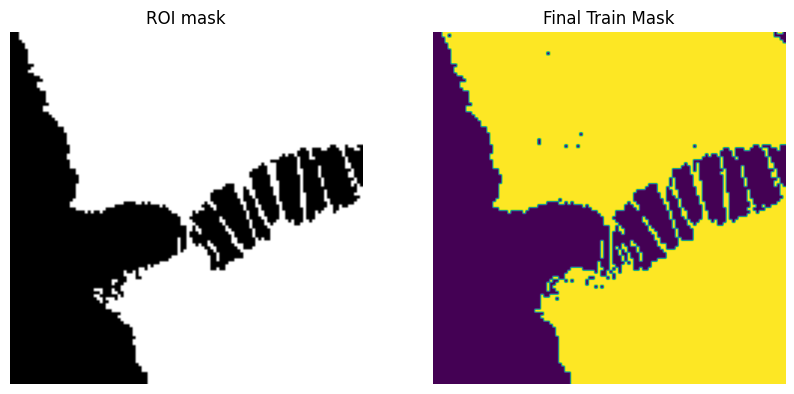

In [290]:
name='efm9' #Filename with which to save exports
topography_file=rf'c:\Users\mcano\Code\rawdata\img_data\EFM9\TopographyEFM9_nm.txt'
ref_file=rf"c:\Users\mcano\Code\rawdata\img_data\EFM9\efm9_ep_map_corrected.txt"
sim_tables_folder=rf'c:\Users\mcano\Code\rawdata\img_data\Bacterias_Ruben\Out_Get_10_EpOnpx_2024-10-16-10-7\tablas'
lift_imgs_folder=rf'c:\Users\mcano\Code\rawdata\preprocessed curves\efm9_curves_calibrated.npy'
raw_curves_folder=0
calibrate_curves=1
ref_flip=1
topo_flip=0


#Curve pre-processing
curves_max_limit=1000 #Maximum height [nm] to which the approximation curves will be projected
curve_nsamples=12 #Number of samples to take from approximation curves
curve_height_setpoint=20 #First curve height [nm] to take in consideration for sampling


#Optional graphics to show in notebook (1 to show images, 0 to hide)
input_imgs_view=1


#Neural Network Setup
pctg=10 #Percentage of train data
cutout_size=9 #Size of the topography cutouts for the convolution operation
kernel_dim=3 #Kernel dimension for the convolution operation
iterations=300
batch_sz=200 #Batch size for training

#Mask configuration. The following images should be processed using the values established.

    #EFM9: binary_threshold=0.04, object_size=3, hole_size=30, m_thresh=0.30
    #EFM8: binary_threshold=0.41, object_size=3, hole_size=30, m_thresh=0.77
    #EFM7: binary_threshold=0.095, object_size=4, hole_size=15, m_thresh=0.44
    #EFVM: binary_threshold=0.05, object_size=2, hole_size=2, m_thresh=0.785
    #newbact: binary_threshold=0.067, object_size=3, hole_size=30, m_thresh=0.30
binary_threshold=0.04
object_size=3
hole_size=30
m_ep_thresh=0.30

d=input_for_nn()
d.preproc()
d.convolution()

In [ ]:
Xn_train_input=pd.DataFrame(np.concatenate((b.Xn_cell, d.Xn_cell),axis=0))
y_train_input=pd.DataFrame(np.concatenate((b.y_cell, d.y_cell), axis=0))
cell_indexes=pd.DataFrame(np.concatenate((b.cell_index, d.cell_index), axis=0))
Cv_train_input=np.concatenate((b.Cv_cell_mat, d.Cv_cell_mat), axis=0)
train_input_index=a.cell_index
labels = np.concatenate((
    np.full(len(b.y_cell), 'b'),
    np.full(len(d.y_cell), 'd'),
))



# Xn_train_input=pd.DataFrame(np.concatenate((a.Xn_cell,b.Xn_cell, d.Xn_cell),axis=0))
# y_train_input=pd.DataFrame(np.concatenate((a.y_cell,b.y_cell, d.y_cell), axis=0))
# cell_indexes=pd.DataFrame(np.concatenate((a.cell_index,b.cell_index, d.cell_index), axis=0))
# Cv_train_input=np.concatenate((a.Cv_cell_mat,b.Cv_cell_mat, d.Cv_cell_mat), axis=0)
# train_input_index=a.cell_index
# labels = np.concatenate((
#     np.full(len(a.y_cell), 'a'),
#     np.full(len(b.y_cell), 'b'),
#     np.full(len(d.y_cell), 'd'),
# ))

# Xn_train_input=a.Xn_cell
# y_train_input=a.y_cell
# Cv_train_input=a.Cv_cell_mat
# train_input_index=a.cell_index




Test-Train Separation

In [ ]:
pctg=5
sss = ShuffleSplit(n_splits=1, test_size=1-(pctg/100), random_state=1)
sss.get_n_splits(Xn_train_input, y_train_input)
train_index, test_index = next(sss.split(Xn_train_input, y_train_input))
train_index=np.sort(train_index)  
test_index=np.sort(test_index)  



X_train, X_test = Xn_train_input.iloc[train_index], Xn_train_input.iloc[test_index]

y_train, y_test = y_train_input.iloc[train_index], y_train_input.iloc[test_index]


indexes_train=cell_indexes.iloc[train_index]

labels_train=labels[train_index]


Cv_train, Cv_test = Cv_train_input[train_index,:,:], Cv_train_input[test_index,:,:]

y_train=pd.DataFrame(np.concatenate((y_train, a.y_select), axis=0))
indexes_train=pd.DataFrame(np.concatenate((indexes_train[0], a.select_index), axis=0))
labels_train=np.concatenate((labels_train, np.full(len(a.y_select), 'a')), axis=0)
X_train=pd.DataFrame(np.concatenate((X_train, a.Xn_select),axis=0))
Cv_train=np.concatenate((Cv_train, a.Cv_sel_mat), axis=0)
a_indexes=indexes_train[labels_train=='a']

Cv_train_aug=data_augment(Cv_train)


N_aug=int(len(Cv_train_aug[:,0,0,0])/len(Cv_train[:,0,0,0]))

X_train_aug=copy(X_train)
y_train_aug=copy(y_train)
for i in np.arange(N_aug-1):
    X_train_aug=pd.DataFrame(np.concatenate((X_train_aug, X_train), axis=0))
    y_train_aug=pd.DataFrame(np.concatenate((y_train_aug, y_train), axis=0))

Network Architecture

In [269]:
#------Example Keras Network------#
reg, histo=nn_for_ep(X_train_aug,Cv_train_aug,y_train_aug,X_test,Cv_test,y_test, verb=1)

Epoch 1/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.2004 - mae: 2.7443 - val_loss: 0.2362 - val_mae: 1.5791
Epoch 2/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2057 - mae: 1.4889 - val_loss: 0.1426 - val_mae: 1.3454
Epoch 3/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1368 - mae: 1.3092 - val_loss: 0.0953 - val_mae: 1.0954
Epoch 4/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0984 - mae: 1.1118 - val_loss: 0.0615 - val_mae: 0.9064
Epoch 5/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0734 - mae: 0.9508 - val_loss: 0.0448 - val_mae: 0.7660
Epoch 6/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0590 - mae: 0.8401 - val_loss: 0.0382 - val_mae: 0.7023
Epoch 7/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0514 - mae: 0.7842 - val_loss: 0.0339 - val_mae: 0.6563
Epoch 8/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0454 - mae: 0.7315 - val_loss: 0.0318 - val_mae: 0.6369
Epoch 9/300
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - lo

Results

In [270]:
Xn_roi=a.Xn_roi
nu_dim=a.nu_dim
roi_index=a.roi_index
cell_index=a.cell_index
y=a.y
y_mat=a.y_mat
y_cell=a.y_cell
Cv_roi_mat=a.Cv_roi_mat
T_mat=a.T_mat

In [271]:
res=reg.predict([Xn_roi, Cv_roi_mat])

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Results visualization

C:\Users\mcano\AppData\Local\Temp\ipykernel_11952\1329319070.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  full_vec_roi[roi_index[i]]=res[i]
C:\Users\mcano\AppData\Local\Temp\ipykernel_11952\1329319070.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  full_vec_cell[cell_index[i]]=res_cell[i]


0.2382


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The error map presents 5720 error values > 1 (3813.33%)


Text(0.5, 0.98, 'Resultado de red neuronal (train data=5%)')

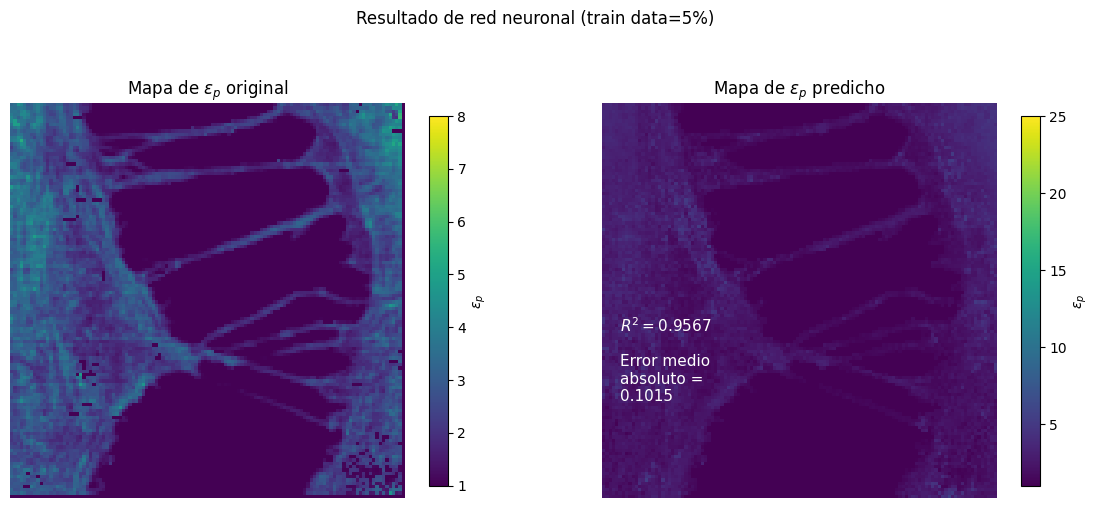

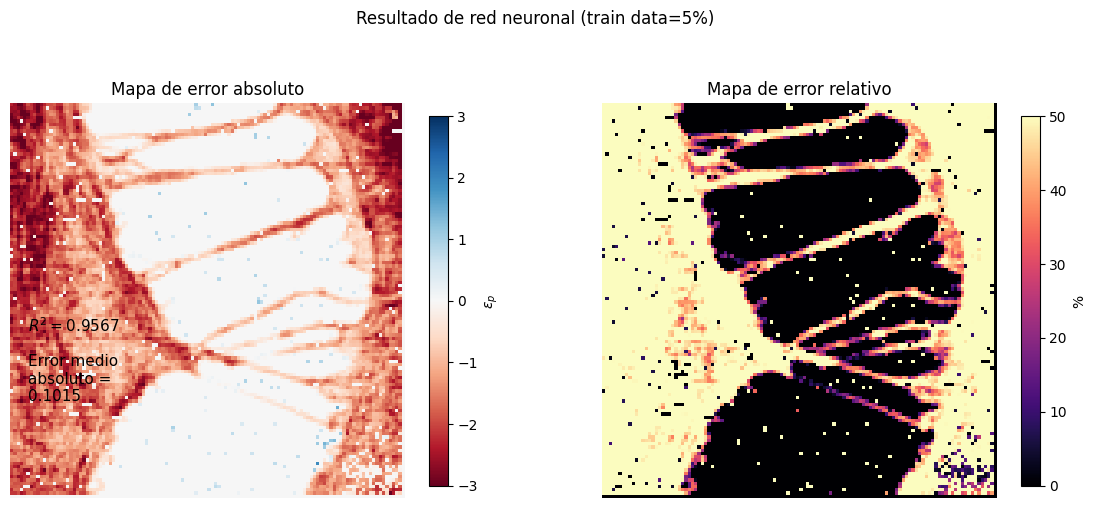

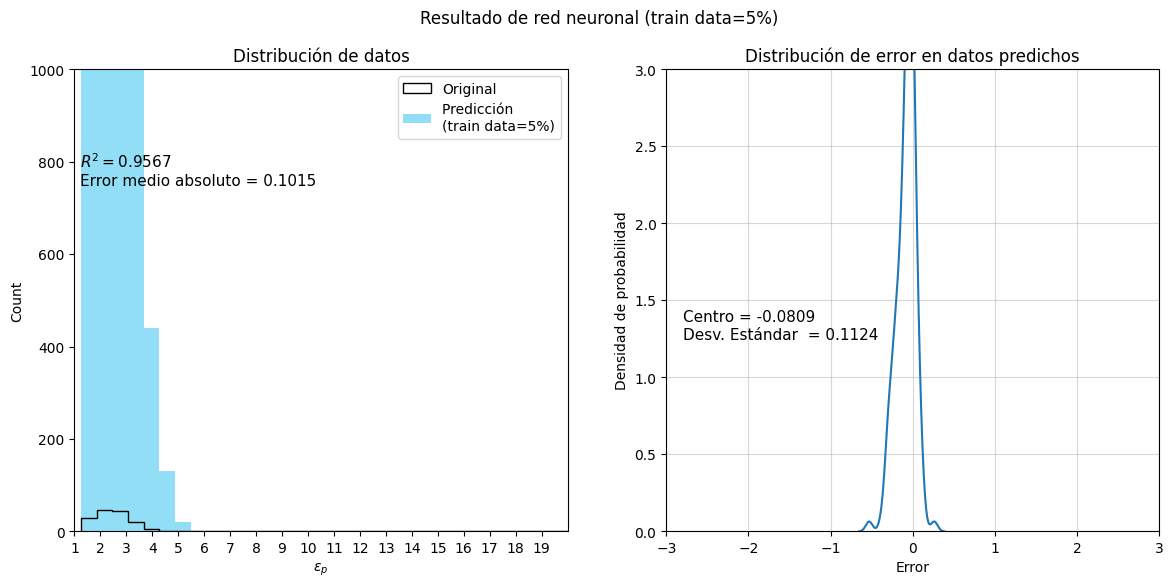

<Figure size 640x480 with 0 Axes>

In [272]:
full_vec_roi=np.zeros(nu_dim**2)+1
for i in np.arange(len(roi_index)):
    full_vec_roi[roi_index[i]]=res[i]


for i in y.index[a_indexes[0]]:
    if i in cell_index and i in a_indexes :
        full_vec_roi[i]=y.iloc[i]

full_img_roi=np.reshape(full_vec_roi,(nu_dim,nu_dim))
full_vec_roi=pd.DataFrame(full_vec_roi)
full_roi=copy(full_vec_roi)
full_cell=pd.DataFrame(full_roi.iloc[roi_index])

#Metrics calculations
res_cell=np.array(full_vec_roi.iloc[cell_index])
full_vec_cell=np.zeros(nu_dim**2)+1
for i in np.arange(len(cell_index)):
    full_vec_cell[cell_index[i]]=res_cell[i]
full_img_cell=np.reshape(full_vec_cell,(nu_dim,nu_dim))

error_map=np.subtract(full_img_cell,y_mat)
error_map_r=(abs(np.subtract(y_mat, full_img_cell))/y_mat)*100

from skimage.metrics import structural_similarity as ssim

ssim = np.round(ssim(y_mat, full_img_cell, data_range=full_img_cell.max() - full_img_cell.min()), decimals=4)
print(ssim)

rsqr_cell=np.round(r2_score(y_cell, res_cell), decimals=4)
mae_cell=mean_absolute_error(y_cell, res_cell)


fig1=plt.figure(figsize=(14,6))

ax=fig1.add_subplot(1,2,1)
pcm=ax.imshow(y_mat, vmin=1, vmax=8)
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_{p}$")
ax.set_title("Mapa de $ε_p$ original")


ax=fig1.add_subplot(1,2,2)
pcm=ax.imshow(full_img_roi, vmin=1, vmax=25)
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_{p}$")
ax.set_title("Mapa de $ε_p$ predicho")
ax.text(5, 90, "$R^2 = $"+str(rsqr_cell)+"\n\nError medio\nabsoluto = \n"+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#fff")#"\n\nSSIM = "+str(ssim)+

fig1.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")

fig2=plt.figure(figsize=(14,6))

ax=fig2.add_subplot(1,2,1)
pcm=ax.imshow(error_map, cmap="RdBu", vmin=-3, vmax=3)
ax.set_title("Mapa de error absoluto")
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="$ε_p$")
ax.text(5, 90, "$R^2 = $"+str(rsqr_cell)+"\n\nError medio\nabsoluto = \n"+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#000")

ax=fig2.add_subplot(1,2,2)
pcm=ax.imshow(error_map_r, cmap="magma", vmin=0, vmax=50)
ax.set_title("Mapa de error relativo")
ax.axis("off")
plt.colorbar(pcm, shrink=0.8, label="%")


fig2.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")

fig3=plt.figure(figsize=(14,6))

ax=fig3.add_subplot(1,2,1)
binss=np.linspace(1.25,20,32)
xaxis=range(int(np.max(binss)))
ax.hist(y_cell, histtype="step", color="#000",bins=binss)
ax.hist(full_cell, histtype="bar", color="#92def7",bins=binss)
ax.set_xticks(xaxis)
ax.set_xlim([1,np.max(binss)])
ax.set_ylim([0,1000])
ax.set_title("Distribución de datos")
ax.legend(["Original","Predicción \n(train data="+str(pctg)+"%)"])
ax.set_xlabel("$ε_{p}$")
ax.set_ylabel("Count")
ax.text(1.2, 750, "$R^2 = $"+str(rsqr_cell)+"\nError medio absoluto = "+str(np.round(mae_cell, decimals=4)), fontsize=11, color="#000")



thresh=1
print("The error map presents "+str(len(error_map[abs(error_map)>thresh]))+" error values > "+str(thresh)+" ("+str(np.round((len(error_map[abs(error_map)>thresh])/len(y_cell))*100, decimals=2))+"%)")
plt.figure()
err=pd.DataFrame(np.subtract(res_cell,y_cell))
ax=fig3.add_subplot(1,2,2)
ax = sns.kdeplot(data=err, ax=ax)
legend=ax.legend()
legend.remove()
ax.set_title("Distribución de error en datos predichos")
ax.set_xlabel("Error")
ax.set_ylabel("Densidad de probabilidad")
ax.set_xlim((-3,3))
ax.set_ylim((0,3))
ax.grid('on', alpha=0.5)
err_mean, err_std=norm.fit(err)
ax.text(-2.8, 1.25, "Centro = "+str(np.round(err_mean, decimals=4))+"\nDesv. Estándar  = "+str(np.round(err_std, decimals=4)), fontsize=11, color="#000")

fig3.suptitle("Resultado de red neuronal (train data="+str(pctg)+"%)")


In [273]:
export=0

filename=rf'{name}_linear'
folder=rf'd:\Exports\pres240510'



if export:
    img_export(filename, folder, full_img_roi, full_cell, topography_file, nu_dim)
    histogram_export(full_cell, filename, folder)


export_ref=0

filename=rf'{name}_sim'
folder=rf'd:\Exports\pres240510'

if export_ref: 
    img_export(filename, folder, y_mat, y_cell, topography_file, nu_dim)
    histogram_export(y_cell, filename, folder)


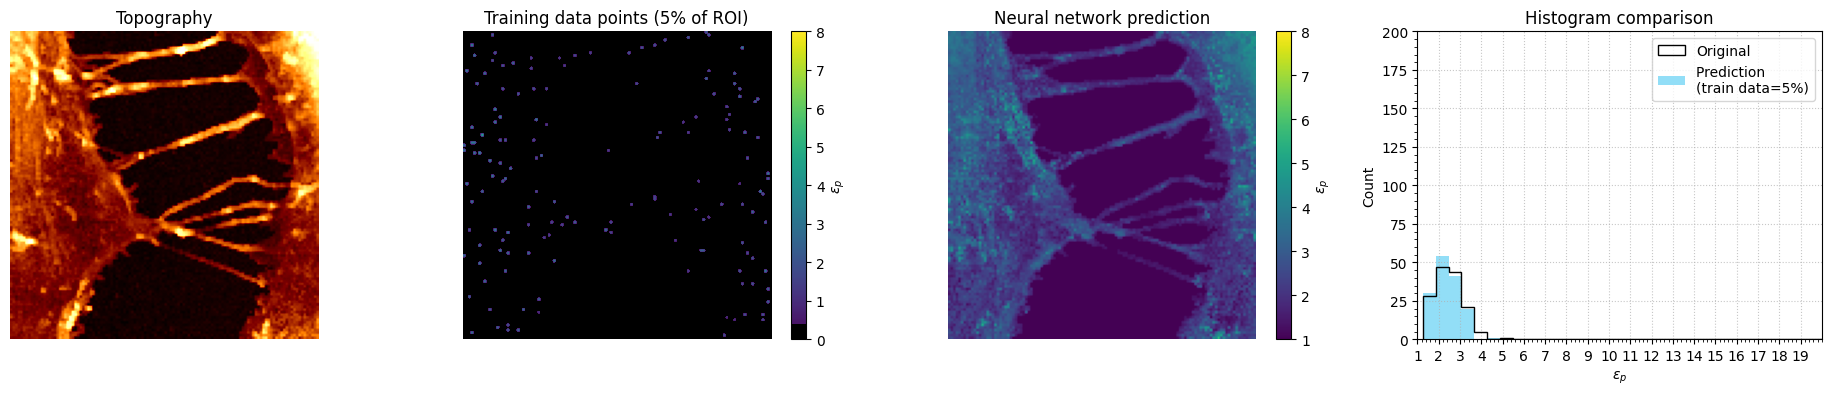

In [278]:
mapp=list(np.zeros((nu_dim**2)))
train_index_for_full_cell=np.array(a_indexes)
mapp=[y.iloc[i,0] if i in train_index_for_full_cell else 0 for i in range(len(mapp))]
mapp=np.array(mapp).reshape(nu_dim,nu_dim)

fig=plt.figure(figsize=(24,4))
ax=fig.add_subplot(1,4,1)
ax.imshow(np.rot90(T_mat,k=4), cmap='afmhot')
ax.set_title('Topography')
ax.axis('off')

ax=fig.add_subplot(1,4,2)
pcm=ax.imshow(np.rot90(mapp,k=4), cmap=newcmp, vmin=0, vmax=8)
ax.set_title(f'Training data points ({pctg}% of ROI)')
ax.axis('off')
plt.colorbar(pcm, label=f'$ε_p$')

ax=fig.add_subplot(1,4,3)
pcm=ax.imshow(np.rot90(full_img_roi,k=4), vmin=1, vmax=8)
ax.set_title('Neural network prediction')
ax.axis('off')
plt.colorbar(pcm, label=f'$ε_p$')

ax=fig.add_subplot(1,4,4)

ax.hist(y_cell, histtype="step", color="#000",bins=binss)
ax.hist(res_cell, histtype="bar", color="#92def7",bins=binss)
ax.set_xticks(xaxis)
ax.set_xlim([1,np.max(binss)])
ax.set_ylim([0,200])
ax.set_title("Histogram comparison")
ax.legend(["Original","Prediction \n(train data="+str(pctg)+"%)"])
ax.set_xlabel("$ε_{p}$")
ax.set_ylabel("Count")
ax.grid('on', linestyle=':', alpha=0.7)
ax.minorticks_on()


Mañana:

* Arreglar topo
* Agregar más bacterias